In [12]:
from IPython.display import HTML
HTML('<style>.cm-comment { color: grey !important; }</style>')

In [24]:
# pip install seqeval

In [34]:
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
ner= pd.read_csv('ner_dataset.csv',  encoding='latin1')

In [26]:
ner

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [29]:
ner['Sentence #'].ffill(inplace=True)

In [30]:
ner.isnull().sum()

Sentence #     0
Word          10
POS            0
Tag            0
dtype: int64

In [31]:
ner[ner['Word'].isnull()]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,NaN,NN,O
256026,Sentence: 11709,NaN,NN,O
257069,Sentence: 11759,NaN,NN,O
571211,Sentence: 26129,NaN,NN,O
613777,Sentence: 28049,NaN,NN,O
747019,Sentence: 34152,NaN,NN,O
901758,Sentence: 41181,NaN,NN,O
903054,Sentence: 41244,NaN,NN,O
944880,Sentence: 43177,NaN,NN,O
1003438,Sentence: 45887,NaN,NN,O


In [32]:
ner['Sentence #'].nunique()

47959

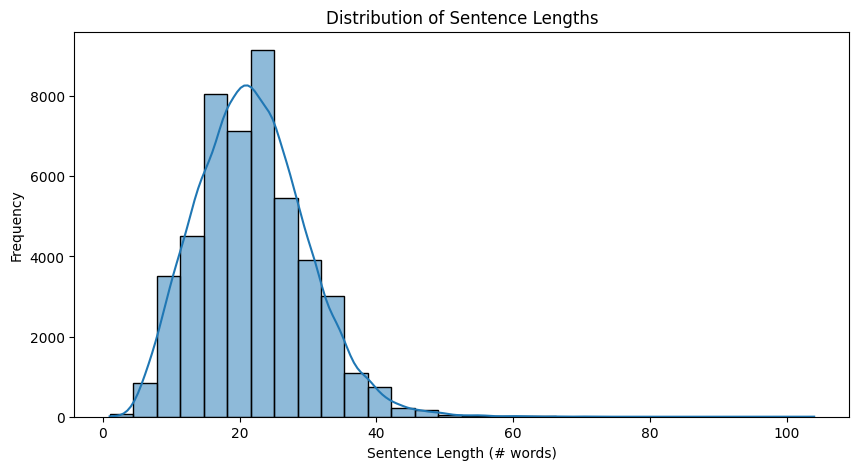

In [35]:
# Sentence length distribution
sentence_lengths = ner.groupby("Sentence #")["Word"].count()
plt.figure(figsize=(10,5))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.xlabel("Sentence Length (# words)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.show()

Total Unique Words: 35177


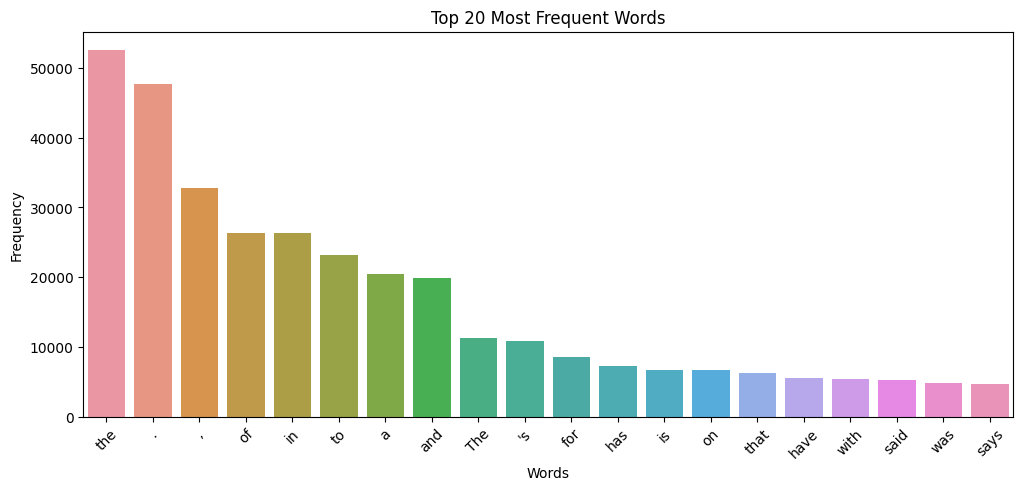

In [36]:
##Word Analysis
# Unique words count
unique_words = ner["Word"].nunique()
print(f"Total Unique Words: {unique_words}")

# Most common words
word_freq = ner["Word"].value_counts().head(20)
plt.figure(figsize=(12, 5))
sns.barplot(x=word_freq.index, y=word_freq.values)
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words")
plt.show()


In [43]:
ner["Tag"].nunique()

17

In [40]:
ner[ner["Tag"]!='O']['Tag']

6          B-geo
12         B-geo
18         B-gpe
42         B-per
65         B-geo
           ...  
1048508    B-gpe
1048518    B-geo
1048521    B-gpe
1048529    B-tim
1048567    B-gpe
Name: Tag, Length: 160667, dtype: object

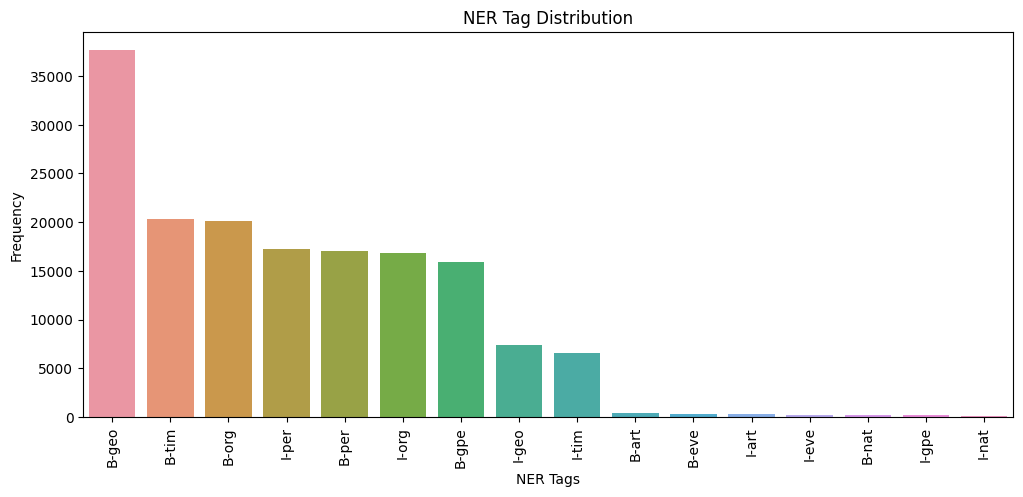

In [41]:
## NET dist
# Count tag occurrences
tag_counts = ner[ner["Tag"]!='O']['Tag'].value_counts()
plt.figure(figsize=(12,5))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.xticks(rotation=90)
plt.xlabel("NER Tags")
plt.ylabel("Frequency")
plt.title("NER Tag Distribution")
plt.show()


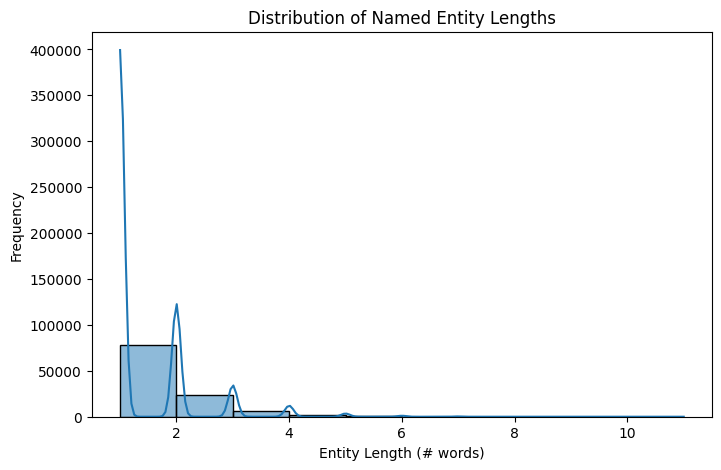

Total Named Entities: 111891
Average Named Entity Length: 1.44 words


In [44]:
# Find named entity chunks
entity_lengths = []
entity_count = 0
current_entity_length = 0

for _, row in ner.iterrows():
    tag = row["Tag"]
    if tag.startswith("B-"):
        if current_entity_length > 0:
            entity_lengths.append(current_entity_length)
        current_entity_length = 1  # Start new entity
        entity_count += 1
    elif tag.startswith("I-"):
        current_entity_length += 1
    else:
        if current_entity_length > 0:
            entity_lengths.append(current_entity_length)
            current_entity_length = 0

# Plot entity length distribution
plt.figure(figsize=(8,5))
sns.histplot(entity_lengths, bins=10, kde=True)
plt.xlabel("Entity Length (# words)")
plt.ylabel("Frequency")
plt.title("Distribution of Named Entity Lengths")
plt.show()

print(f"Total Named Entities: {entity_count}")
print(f"Average Named Entity Length: {np.mean(entity_lengths):.2f} words")


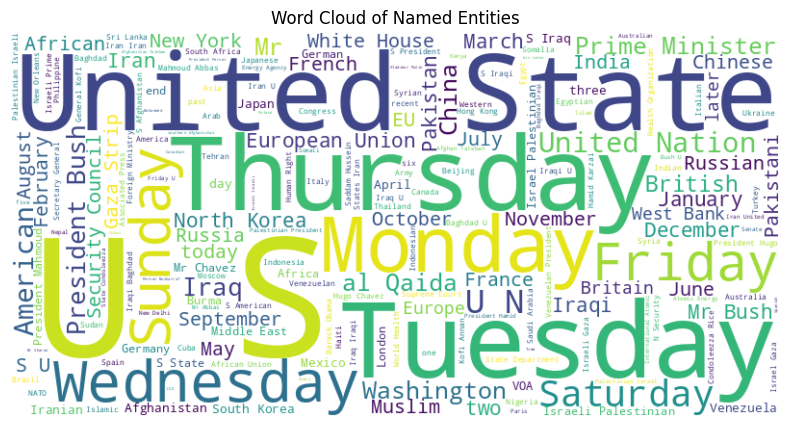

In [46]:
## Word CLoud
from wordcloud import WordCloud

# Extract only named entities (non-"O" tags)
named_entities = ner[ner["Tag"] != "O"]["Word"].values

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(named_entities))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Named Entities")
plt.show()


In [48]:
ner.dropna(inplace=True)

In [47]:
# Preprocessing
def preprocess_data(df):
    # Forward fill sentence numbers
    df['Sentence #'] = df['Sentence #'].ffill()
    
    # Group words by sentences
    sentences = defaultdict(list)
    tags = defaultdict(list)
    
    for _, row in df.iterrows():
        sentences[row['Sentence #']].append(row['Word'].lower())
        tags[row['Sentence #']].append(row['Tag'])
    
    return list(sentences.values()), list(tags.values())


In [49]:
X, y = preprocess_data(ner)

In [55]:
len(X)

47959

In [14]:
len(X[0])

24

In [15]:
X
len(y[0])

24

In [56]:
# First split: 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: 70% train, 10% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42  # 0.125*0.8=0.1
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 33571
Validation samples: 4796
Test samples: 9592


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Feature Engineering
def word2features(sent, i):
    word = sent[i]
    return {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

# Prepare training data
X_train_features = []
y_train_flat = []

for sentence, tags in zip(X_train, y_train):
    for i in range(len(sentence)):
        X_train_features.append(word2features(sentence, i))
        y_train_flat.append(tags[i])



In [28]:
X_train[0]

['the',
 'czech',
 'republic',
 'produced',
 'more',
 'than',
 'a',
 'million',
 'cars',
 'for',
 'the',
 'first',
 'time',
 'in',
 '2010',
 ',',
 'over',
 '80',
 '%',
 'of',
 'which',
 'were',
 'exported',
 '.']

In [58]:
X_train_features[0]
# y_train_flat[0:24]

{'word.lower()': 'iran',
 'word[-3:]': 'ran',
 'word.isupper()': False,
 'word.istitle()': False,
 'word.isdigit()': False}

In [29]:
# Vectorize features and encode labels
vec = DictVectorizer()
X_train_vec = vec.fit_transform(X_train_features)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_flat)

In [32]:
y_train_enc

array([16,  2, 10, ..., 16, 16, 16])

In [33]:
# Train model
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_vec, y_train_enc)

# Evaluation helper
def evaluate_model(model, X, y):
    y_pred = []
    for sentence in X:
        sent_features = [vec.transform(word2features(sentence, i)) for i in range(len(sentence))]
        preds = model.predict([x.toarray()[0] for x in sent_features])
        y_pred.append(le.inverse_transform(preds))
    
    y_true_flat = [tag for sent in y for tag in sent]
    y_pred_flat = [tag for sent in y_pred for tag in sent]
    
    print(classification_report(y_true_flat, y_pred_flat))


In [34]:
# Evaluate baseline
print("Baseline Model Validation Performance:")
evaluate_model(baseline_model, X_val, y_val)

Baseline Model Validation Performance:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       B-art       0.33      0.03      0.06        32
       B-eve       0.75      0.38      0.50        16
       B-geo       0.75      0.84      0.79      2525
       B-gpe       0.92      0.92      0.92      1084
       B-nat       0.46      0.50      0.48        12
       B-org       0.74      0.40      0.52      1425
       B-per       0.71      0.62      0.67      1230
       B-tim       0.87      0.74      0.80      1423
       I-art       0.00      0.00      0.00        32
       I-eve       0.00      0.00      0.00        11
       I-geo       0.67      0.52      0.59       481
       I-gpe       0.44      0.20      0.28        20
       I-nat       0.00      0.00      0.00         3
       I-org       0.59      0.24      0.34      1180
       I-per       0.73      0.65      0.69      1279
       I-tim       0.65      0.13      0.21       468
           O       0.96      0.99      0.98     61526

    accuracy              

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# # Evaluate test data
# print("Baseline Model Validation Performance:")
# evaluate_model(baseline_model, X_test, y_test)

In [22]:
# len(X_test)


### New Approach- BILSTM

In [ ]:
# pip install tensorflow-addons

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:


# Load Data
df = pd.read_csv("ner_dataset.csv", encoding="latin1")
# df= pd.read_csv('C:/Users/bharat.sakarwal/Downloads/ner dataset/ner_dataset.csv',  encoding='latin1')

# Fill missing Sentence # values (forward fill)
df['Sentence #'] = df['Sentence #'].fillna(method='ffill')

# Remove POS column since it's not needed
df = df.drop(columns=['POS'])

# Convert dataframe into structured sentences format
sentences = []
sentence = []

for _, row in df.iterrows():
    word, tag = row['Word'], row['Tag']
    sentence.append((word, tag))
    
    if row['Word'] == ".":
        sentences.append(sentence)
        sentence = []

print(f"Total sentences: {len(sentences)}")



2025-02-03 07:54:58.898738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-03 07:55:15.067496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Total sentences: 47761


In [4]:
# Extract words and tags
words = list(set(df["Word"].values))
tags = list(set(df["Tag"].values))

# Add padding word
words.append("PAD")
tags.append("PAD")

n_words = len(words)
n_tags = len(tags)

print(f"Unique Words: {n_words}, Unique Tags: {n_tags}")

# Encode words and tags
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

max_len = 50  # Max sentence length
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(X, maxlen=max_len, padding="post")

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(y, maxlen=max_len, padding="post")

y = [to_categorical(i, num_classes=n_tags) for i in y]





Unique Words: 35179, Unique Tags: 18


In [59]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
len(X_train),len(X_test)

(38367, 9592)

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build BiLSTM Model
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len, mask_zero=True)(input_word)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)
model = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

model = Model(input_word, model)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=4          # Stop after 4 epochs without improvement
    # restore_best_weights=True,  # Restore the best model weights
)

# Train Model
history = model.fit(X_train, np.array(y_train), validation_data=(X_test, np.array(y_test)), batch_size=32, epochs=10, callbacks=[early_stopping],verbose=1)

# Evaluate Model
model.evaluate(X_test, np.array(y_test))

Epoch 1/10
1194/1194 [==============================] - 75s 58ms/step - loss: 0.3395 - accuracy: 0.9165 - val_loss: 0.1383 - val_accuracy: 0.9597
Epoch 2/10
1194/1194 [==============================] - 68s 57ms/step - loss: 0.1064 - accuracy: 0.9684 - val_loss: 0.1139 - val_accuracy: 0.9654
Epoch 3/10
1194/1194 [==============================] - 68s 57ms/step - loss: 0.0795 - accuracy: 0.9755 - val_loss: 0.1090 - val_accuracy: 0.9674
Epoch 4/10
1194/1194 [==============================] - 68s 57ms/step - loss: 0.0662 - accuracy: 0.9790 - val_loss: 0.1076 - val_accuracy: 0.9674
Epoch 5/10
1194/1194 [==============================] - 68s 57ms/step - loss: 0.0571 - accuracy: 0.9814 - val_loss: 0.1129 - val_accuracy: 0.9674
Epoch 6/10
1194/1194 [==============================] - 68s 57ms/step - loss: 0.0502 - accuracy: 0.9835 - val_loss: 0.1178 - val_accuracy: 0.9669
Epoch 7/10
1194/1194 [==============================] - 68s 57ms/step - loss: 0.0439 - accuracy: 0.9854 - val_loss: 0.1237 -

[0.12927107512950897, 0.9663500785827637]

In [8]:
model.evaluate(X_test, np.array(y_test))

299/299 [==============================] - 6s 20ms/step - loss: 0.1293 - accuracy: 0.9664


[0.12927107512950897, 0.9663500785827637]

In [21]:

# Predict Function
def predict_sentence(sentence):
    words = sentence.split()
    encoded_sentence = [word2idx.get(w, word2idx["PAD"]) for w in words]
    padded_sentence = pad_sequences([encoded_sentence], maxlen=max_len, padding="post")
    
    prediction = model.predict(padded_sentence)
    predicted_tags = [list(tag2idx.keys())[np.argmax(p)] for p in prediction[0]]
    
    for w, t in zip(words, predicted_tags[:len(words)]):
        print(f"{w}: {t}")

# Example Prediction
predict_sentence("Michael visited New York from London.")

1/1 [==============================] - 0s 35ms/step
Michael: B-per
visited: O
New: B-geo
York: I-geo
from: O
London.: B-geo
